In [1]:
from kk_all import *
import keras.backend as K
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
Failed to import duecredit due to No module named 'duecredit'


In [2]:
def test_uncertainty(model_file, x_test, y_test, n=500):
    model = get_model()
    model.load_weights(model_file)
    predict_stochastic = K.Function(model.inputs + [K.learning_phase()], [model.layers[-1].output])
    y_prob = np.zeros(y_test.shape)

    for i in range(n):
        y_pred = predict_stochastic([x_test, True])[0]
        y_prob += y_pred
    y_prob /= n
    
    return y_prob, model

In [3]:
cheng_data = np.load("./cheng_data_hints.npz")

In [4]:
bb = cheng_data["bigM_base"]
bb[:,:,:,1] = 0
cheng_nohint_pred = test_uncertainty("./test_ak_0000/model.h5", 
                                    bb,
                                    cheng_data["bigM_mask"],
                                    50)

/home/keshavan/anaconda3/lib/python3.6/site-packages/keratin-0.1.dev0-py3.6.egg/keratin/networks.py:179: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [5]:
def mplfig_base(data, outfile):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(float(data.shape[1])/data.shape[0], 1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, aspect='normal', cmap=plt.cm.Greys_r)
    fig.savefig(outfile, dpi=data.shape[0])
    plt.close()

In [6]:
def mplfig_overlay(data, outfile, cmap, vmin, vmax):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(float(data.shape[1])/data.shape[0], 1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, aspect='normal', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.savefig(outfile, dpi=data.shape[0], transparent=True)
    plt.close()

In [7]:
from os.path import join

def make_figures(bigM_base, bigM_mask, predictions, outpath="predictions/", **kwargs):
    for i, img in enumerate(bigM_base):
        
        b = bigM_base[i,:,:,0]
        t = bigM_mask[i,:,:,0]
        t[t<0.01] = np.nan
        a = bigM_base[i,:,:,1]
        a[a<0.01] = np.nan
        p = predictions[i,:,:,0]
        p[p<0.01] = np.nan
        
        #outpath = "predictions/"
        mplfig_base(b, join(outpath,"base%04d.jpg" % i))
        mplfig_overlay(p, join(outpath,"pred%04d.png" % i), plt.cm.viridis, 0, 1)
        mplfig_overlay(t, join(outpath,"truth%04d.png" % i), plt.cm.Reds, 0, 1)
        mplfig_overlay(a, join(outpath,"agg%04d.png" % i), plt.cm.Blues, 0, 1)

In [8]:
cheng_nohint_pred.shape

(141, 256, 256, 1)

In [9]:
make_figures(bb, cheng_data["bigM_mask"], predictions=cheng_nohint_pred, 
             outpath="../dl_viewer_nohint/predictions/")

/home/keshavan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The normal aspect was deprecated in version 1.2. Use auto instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [10]:
from scipy.stats import entropy

In [21]:
import pandas as pd
df = pd.DataFrame(columns=["entropy", "mean", "std"])
for pred in cheng_nohint_pred:
    pred = pred.ravel()
    pred = pred[np.isfinite(pred)]
    entry = {}
    entry["entropy"] = entropy(pred)
    entry["mean"] = np.mean(pred)
    entry["std"] = np.std(pred)
    df = df.append(entry, ignore_index=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4458312780>]], dtype=object)

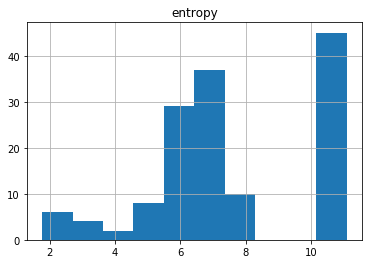

In [23]:
df.hist("entropy")

In [24]:
df.to_csv("round1_entropy_cheng.csv")

In [32]:
from nipype.utils.filemanip import load_json, save_json
manifest = load_json("../dl_viewer_nohint/prediction_manifest.json")

In [29]:
new_m = []
for i, m in enumerate(manifest):
    new_m.append({"id": m, "data": df.iloc[i].to_dict()})

In [34]:
save_json("../dl_viewer_nohint/pred_manifest_metrics.json", new_m)

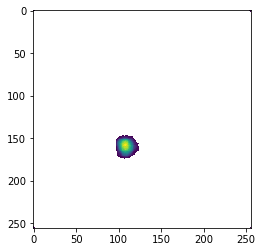

In [16]:
plt.imshow(pred[:,:,0])

In [18]:
entropy(pred.ravel())

6.0085969899003295

In [7]:
y_prob[y_prob<0.00001] = np.nan

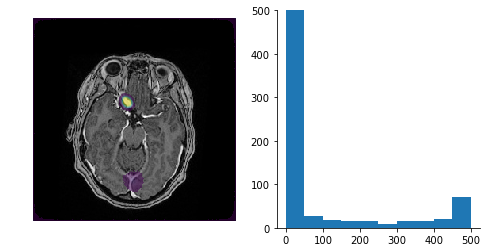

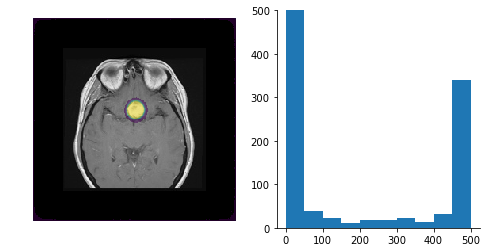

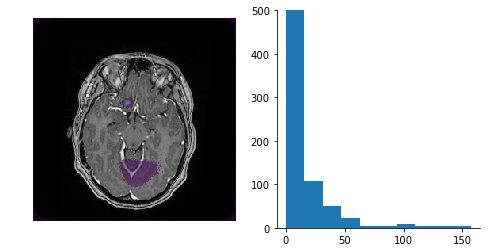

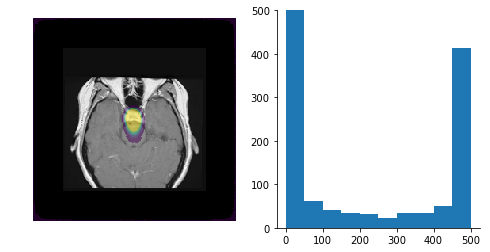

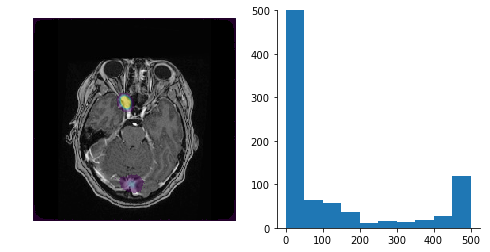

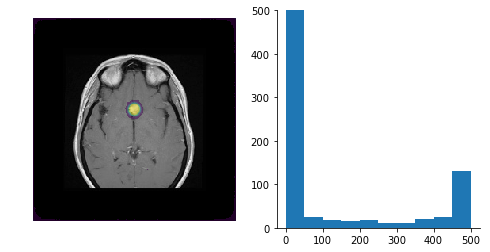

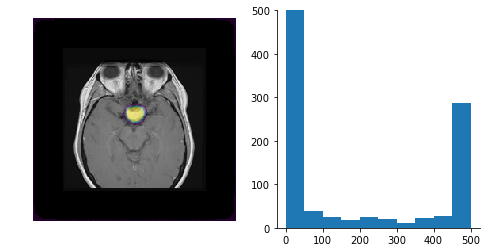

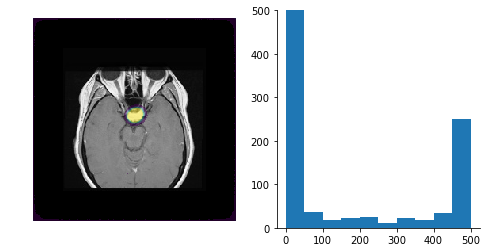

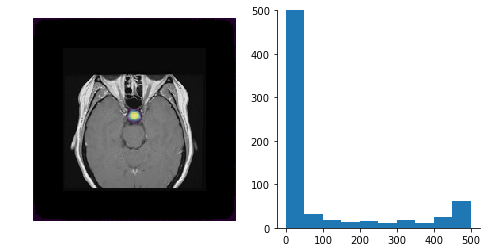

In [44]:
data["y_test"][data["y_test"] < 0.1] = np.nan
for i in range(data["x_test"].shape[0]):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].imshow(data["x_test"][i,:,:,0], cmap=plt.cm.Greys_r)
    #plt.imshow(data["y_test"][i,:,:,0], cmap=plt.cm.Reds, vmin=1, vmax=2, alpha=0.5)
    ax[0].imshow(y_prob[i,:,:,0], alpha=0.5, vmin=0, vmax=500)
    ax[0].axis("off")
    yp = y_prob[i,:,:,0].ravel()
    yp = yp[np.isfinite(yp)]
    yp = yp[yp>50] #greater than 10% prob
    ax[1].hist(yp)
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    ax[1].set_ylim([0,500])